# Downsampling
## Idea:
* Two dataset variants have different sizes, need same size to compare other dataset properties
* -> sample down the larger one, i.e. draw a random sample
## Potential Risks:
* are other dataset properties affected by the downsampling?
    * Overlap
    * Error rate
    * Attribute-value frequencies, skewnesses

In [4]:
# get the dataset
import pandas as pd
# get the data
filepath = "data/2021_NCVR_Panse_001/dataset_ncvr_dirty.csv"
col_names = "sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE".split(",")
df = pd.read_csv(filepath, names=col_names, dtype={"PLZ": str, "YEAROFBIRTH": int},
                              keep_default_na=False)
df.head()

,sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE
0,A,AM28693,1fdc308dcc35344c6d5c20845fad641d,SUE,BARNES,SHUFFLER,1946,,BURKE,VALDESE,28690,LAKEVIEW ACRES,F,NL,W
1,A,CZ67291,b36b8c16c743ed415c6a7f3fc1a3b859,RONALD,EUGENE,LATTIMER,1953,OH,MOORE,PINEHURST,28374,BURNING TREE,M,NL,W
2,A,BN204837,401b7f6f5e107dbb009da197a2b05d9e,DEIDRE,MARLANA,MARTIN,1973,NC,FORSYTH,WINSTON SALEM,27105,CARVER GLEN,F,NL,B
3,A,EH737737,85f059d91b803b5835a8b9762a3170cb,KURT,,BALEN,1968,PA,WAKE,APEX,27502,ASHLEY DOWNS,M,NL,W
4,A,DT41462,f70a42ce915731cabafc5daa1bfbceeb,WORTH,BROWN,FOUTZ,1919,,ROWAN,SALISBURY,28146,MORRISON,M,NL,W


## 1. Does Downsampling affect overlap?
#### @Florens, 1. kannst du eigentlich überspringen, habs nur mit rein getan falls du doch genauer wissen willst, wie die downsampling Methode funktioniert und wie sie zustande gekommen ist.

In [5]:
def get_overlap(df1: pd.DataFrame, df2: pd.DataFrame, global_id_col_name="globalID"):
    """
    Returns overlap of a given dataset. Overlap is calculated wrt. size of one source,
    which means that if there are two datasets A and B with each 100 records,
    20 of which are matches and 80 non-matches, then the overlap will be 0.2.
    :param df1: All records in source A
    :param df2: All records in source B
    :return: Overlap value between 0 and 1.
    :rtype: float
    """
    df = pd.concat([df1, df2])
    intersect = pd.merge(df1, df2, how="inner", on=[global_id_col_name])
    return 2 * intersect.shape[0] / df.shape[0]

In [6]:
def split_by_source_id(df: pd.DataFrame, source_id_col_name="sourceID", number_of_sources=2):
    sources = [x for _, x in df.groupby(source_id_col_name)]
    if number_of_sources is not None and len(sources) != number_of_sources:
        raise ValueError(f"Expected {number_of_sources} sources but found {len(sources)}.")
    return sources

In [7]:
def split_and_get_overlap(df: pd.DataFrame, global_id_col_name="globalID", source_id_col_name="sourceID",
                          number_of_sources=2):
    df1, df2 = split_by_source_id(df, source_id_col_name, number_of_sources)
    return get_overlap(df1, df2, global_id_col_name)

In [8]:
split_and_get_overlap(df)

0.2

In [9]:
sample = df.sample(100_000, random_state=42)
split_and_get_overlap(sample)

0.1007

In [10]:
sample = df.sample(50_000, random_state=42)
split_and_get_overlap(sample)

0.04996

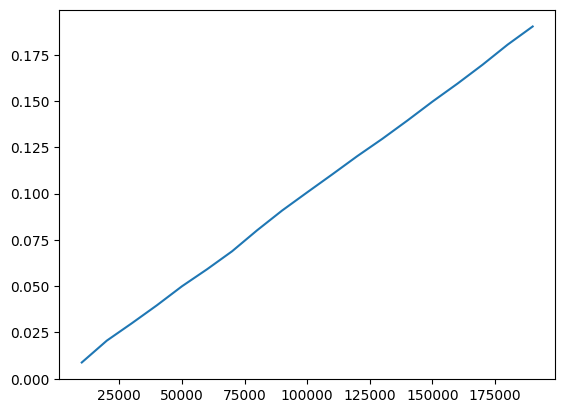

In [11]:
import matplotlib.pyplot as plt

sizes = [*range(10_000, 200_000, 10_000)]
overlaps = [split_and_get_overlap(df.sample(size, random_state=42))
            for size in sizes]
plt.plot(sizes, overlaps)

### Observation:
Sample size and overlap are linearly correlated

### Solution Approach:
Split dataset into matches and non-matches, draw from each, then recombine:

In [12]:
def get_true_matches(df1: pd.DataFrame, df2: pd.DataFrame, global_id_col_name="globalID") -> (pd.DataFrame, pd.DataFrame):
    """
    Return form each source all records that are part of the overlap, aka all records that have a true match in the
    other source.
    Returned as tuple of two dataframes, one for each sourceID.
    They are not linked to their partners, i.e. the dataframes have no specific order.
    """
    true_matches_1 = df1[df1[global_id_col_name].isin(df2[global_id_col_name])]
    true_matches_2 = df2[df2[global_id_col_name].isin(df1[global_id_col_name])]
    return true_matches_1, true_matches_2

## Downsampling Method:

In [13]:
def random_sample(df_a: pd.DataFrame, df_b:pd.DataFrame, total_sample_size: int, seed: int = None, overlap: float = None,
                  global_id_col_name="globalID") -> pd.DataFrame:
    """
    Draw random sample with specified overlap. If overlap is not specified, preserve the overlap from the passed data.
    :param df_a: All records of source A
    :param df_b: All records of source B
    """
    if df_a.shape[0] != df_b.shape[0]:
        raise ValueError("df_a and df_b must be of the same size.")
    df = pd.concat([df_a, df_b])
    if not (total_sample_size % 2 == 0):
        raise ValueError(f"total_size must be divisible by 2. Each source in the random sample will have half the "
                         f"size of total_size")
    size = int(total_sample_size / 2)
    if not (0 <= size <= df_a.shape[0]):
        raise ValueError(
            f"Size must be between 0 and size of one of the two source data sets (={df_a.shape[0]}). Got {size} instead.")
    rel_sample_size = size / df.shape[0]
    base_overlap = get_overlap(df_a, df_b)
    max_overlap = min(1.0, base_overlap / rel_sample_size)
    non_matches_count = df.shape[0] - base_overlap * df_a.shape[0]
    min_overlap = max(0.0, 1 - non_matches_count / total_sample_size)
    if overlap is None:
        overlap = base_overlap
    if not (min_overlap <= overlap <= max_overlap or overlap is None):
        raise ValueError(f"Overlap must be between {min_overlap} and {max_overlap}. Got {overlap} instead.")
    true_matches1, true_matches2 = get_true_matches(df_a, df_b, global_id_col_name)
    # draw size*overlap from true matches of source A
    a_matches = true_matches1.sample(round(size * overlap), random_state=seed)
    # draw size*(1-overlap) from non-matches of source A
    a_non_matches = df_a[~df_a[global_id_col_name].isin(true_matches1[global_id_col_name])] \
        .sample(round(size * (1 - overlap)), random_state=seed)
    # draw size*overlap from true matches of source B
    b_matches = true_matches2.sample(round(size * overlap), random_state=seed)
    # draw size*(1-overlap) from non-matches of source B
    b_non_matches = df_b[~df_b[global_id_col_name].isin(true_matches2[global_id_col_name])] \
        .sample(round(size * (1 - overlap)), random_state=seed)
    # concatenate all
    return pd.concat([a_matches, a_non_matches, b_matches, b_non_matches])

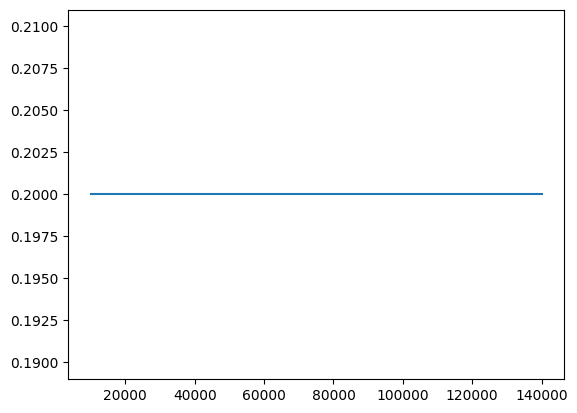

In [14]:
df_a, df_b = split_by_source_id(df)
sizes = [*range(10_000, 150_000, 10_000)]
overlaps = [split_and_get_overlap(random_sample(df_a, df_b, size, seed=42))
            for size in sizes]
plt.plot(sizes, overlaps)

Looks good!

## 2. Does this downsampling method affect attribute value frequencies?

### Idea: Describe attr. value frequency-distribution by its skewness
#### Skewness of first name

In [15]:
from scipy.stats import ttest_ind

def compare_skews(df1, df2, attr_name, sample_size, iterations):
    skews1 = []
    skews2 = []
    for i in range(iterations):
        # to compare skewness, need same sized random subsets (skew is amplified by dataset size)
        skew1, skew2 = [df[attr_name].sample(sample_size,
                                             random_state=i).value_counts().skew()
                        for df in (df1, df2)]
        skews1.append(skew1)
        skews2.append(skew2)
    return ttest_ind(skews1, skews2).pvalue

In [16]:
# split dataset into two sources a and b
df_a, df_b = split_by_source_id(df)

In [31]:
downsampling_size = 50_000
sample_size = 10_000
iterations = 1000
seed = 42
df_res = random_sample(df_a, df_b, downsampling_size, seed)
compare_skews(df, df_res, "FIRSTNAME", sample_size, iterations)

0.41637549799938256

In [32]:
seed = 43
df_res = random_sample(df_a, df_b, downsampling_size, seed)
compare_skews(df, df_res, "FIRSTNAME", sample_size, iterations)

3.216433591828427e-19

### Nur durch Veränderung des Seeds komplett anderes Ergebnis
* Erwartung war eigentlich, mit den vielen Iterationen den Zufallsfaktor auszugleichen
* D.h. vllt stimmt etwas mit der compare_skews Methode nicht.
* Vielleicht ist aber auch die Sample Größe (50k) einfach zu klein, sodass schon mal durch Zufall eine etwas andere Attributwert-Verteilung heraus kommen kann? Dann bräuchte ich zum Testen einen größeren Datensatz (ca 1M)

In [45]:
# a closer look at the skew lists
df1 = df
df2 = df_res
skews1 = []
skews2 = []
for i in range(iterations):
    # to compare skewness, need same sized random subsets (skew is amplified by dataset size)
    skew1, skew2 = [df.FIRSTNAME.sample(sample_size,
                                         random_state=i).value_counts().skew()
                    for df in (df1, df2)]
    skews1.append(skew1)
    skews2.append(skew2)

In [47]:
from scipy.stats import describe

In [48]:
describe(skews1)

DescribeResult(nobs=1000, minmax=(7.944169414740913, 9.967781291470358), mean=8.858960652745031, variance=0.10468497978797489, skewness=0.21115252662227504, kurtosis=0.00017616731422309684)

In [49]:
describe(skews2)

DescribeResult(nobs=1000, minmax=(7.840514802745674, 9.707595824569646), mean=8.73600791756071, variance=0.0797711299276887, skewness=0.07855222258322854, kurtosis=0.09130214238790346)

In [51]:
import seaborn as sns

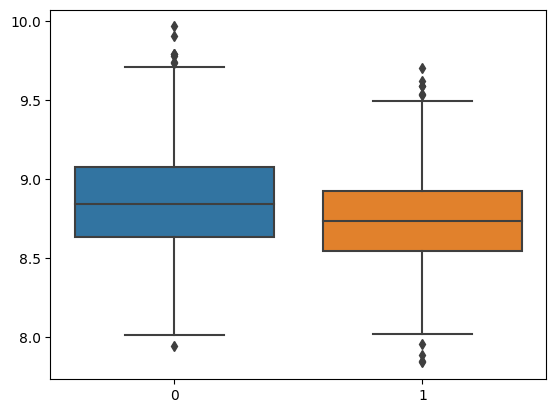

In [56]:
sns.boxplot(data=[skews1, skews2])
plt.show()

In [74]:
from tqdm import tqdm

def compare_skews2(df, downsampling_size, attr_name, sample_size, iterations, seed_incr=0):
    df_a, df_b = split_by_source_id(df)
    skews1 = []
    skews2 = []
    for i in tqdm(range(iterations)):
        df_res = random_sample(df_a, df_b, downsampling_size, seed=i+seed_incr)
        skew1, skew2 = [
            _df.sample(sample_size, random_state=i)[attr_name].value_counts().skew()
            for _df in (df, df_res)
        ]
        skews1.append(skew1)
        skews2.append(skew2)
    return (skews1, skews2)

In [66]:
downsampling_size = 5000
sample_size = 1000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [07:55<00:00,  2.10it/s]


0.05193975536287609

In [68]:
downsampling_size = 5000
sample_size = 1000
iterations = 100
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


0.5271192065009521

In [69]:
downsampling_size = 10_000
sample_size = 1000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s]


0.06070039904807875

In [70]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [10:05<00:00,  1.65it/s]


0.8450119407899201

In [72]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=1)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [08:42<00:00,  1.92it/s]


0.544166396644953

In [75]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=2)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [08:59<00:00,  1.86it/s]


0.9149762755309175

In [76]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=3)
ttest_ind(skews1, skews2).pvalue

100%|██████████| 1000/1000 [09:26<00:00,  1.76it/s]


0.5269670447139234